In [1]:
# Import libraries for data analysis and visualization
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Import libraries for neural network model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import load_model

# Import libraries for normalization and model evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

# For visualizations we will use ggplot stlye and Century Gothic as font family
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Century Gothic' 

## 1. Data processing

In [2]:
# Import the dataset
electric_generation_df = pd.read_csv('../Datasets/electric_generation_cenace_2020-2023.csv')

# Show the first rows
electric_generation_df.head()

,Date,Time,Wind,Photovoltaics,Biomass,Coal,CombinedCycle,InternalCombustion,Geothermal,Hydro,Nuclear,Thermal,Gas
0,01/01/2020,1,2063.4865,0.0,27.2993,1303.8717,15892.6664,223.6676,553.4592,1009.2008,1562.6114,1803.5191,1385.3987
1,01/01/2020,2,1854.1446,0.0,27.2328,1124.3932,15666.2708,213.9600,553.5832,830.7762,1563.6830,1796.4708,1400.2806
2,01/01/2020,3,1619.9672,0.0,25.9690,969.8357,15261.6677,209.9307,552.9112,782.0985,1563.5340,1790.3642,1400.7257
3,01/01/2020,4,1616.7096,0.0,26.3340,967.9433,14661.8918,206.6082,552.8451,678.8264,1563.1209,1785.4772,1399.7275
4,01/01/2020,5,1658.9632,0.0,25.8570,968.7607,14166.5939,205.1467,553.3489,699.4795,1563.7447,1785.2862,1382.3953


In [3]:
# Add a new column with the total energy produced per hour
electric_generation_df['Total (MWh)'] = electric_generation_df.iloc[:, 2:].sum(axis=1).astype(float)

In [4]:
# Show new dataframe
electric_generation_df.head()

,Date,Time,Wind,Photovoltaics,Biomass,Coal,CombinedCycle,InternalCombustion,Geothermal,Hydro,Nuclear,Thermal,Gas,Total (MWh)
0,01/01/2020,1,2063.4865,0.0,27.2993,1303.8717,15892.6664,223.6676,553.4592,1009.2008,1562.6114,1803.5191,1385.3987,25825.1807
1,01/01/2020,2,1854.1446,0.0,27.2328,1124.3932,15666.2708,213.9600,553.5832,830.7762,1563.6830,1796.4708,1400.2806,25030.7952
2,01/01/2020,3,1619.9672,0.0,25.9690,969.8357,15261.6677,209.9307,552.9112,782.0985,1563.5340,1790.3642,1400.7257,24177.0039
3,01/01/2020,4,1616.7096,0.0,26.3340,967.9433,14661.8918,206.6082,552.8451,678.8264,1563.1209,1785.4772,1399.7275,23459.4840
4,01/01/2020,5,1658.9632,0.0,25.8570,968.7607,14166.5939,205.1467,553.3489,699.4795,1563.7447,1785.2862,1382.3953,23009.5761


In [5]:
# Re-build the dataframe just with Date, Time and Total (Mwh)
electric_generation_df = electric_generation_df[['Date', 'Time', 'Total (MWh)']]

In [6]:
# This function creates sequences to feed the neural network
def create_sequences(data, n_steps):
    X, y = [], []
    
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps), 0])
        y.append(data[i + n_steps, 0])
    
    return np.array(X), np.array(y)

In [7]:
# Data normalization
scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(electric_generation_df[['Total (MWh)']])

In [8]:
# Use the last 5 hours to predict the next hour
n_steps = 10

# Create temporaly sequences
X, y = create_sequences(data, n_steps)

# Split into train (80%) and test sets (20%)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for LSTM (sample number, temporary steps)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

## 2. Neural Network Design

In [9]:
# Initialize model
modelo = Sequential()

# Add first LSTM layer and dropout regularization (10%)
modelo.add(LSTM(units = 70, return_sequences = True, activation='relu', input_shape=(X_train.shape[1], 1)))
modelo.add(Dropout(0.1))

# Add second LSTM layer and dropout regularization (10%)
modelo.add(LSTM(units = 100, return_sequences = True))
modelo.add(Dropout(0.1))

# Add third LSTM layer and dropout regularization (10%)
modelo.add(LSTM(units = 70))
modelo.add(Dropout(0.1))

# Add output layer
modelo.add(Dense(units = 1))

# Compile the model
modelo.compile(optimizer = 'adam', loss='mse')

# Train the model
history = modelo.fit(X_train, y_train, epochs = 100, validation_data=(X_test, y_test))



Epoch 1/100

877/877 [==============================] - 25s 20ms/step - loss: 0.0070 - val_loss: 8.0464e-04
Epoch 2/100
877/877 [==============================] - 17s 19ms/step - loss: 0.0016 - val_loss: 7.0381e-04
Epoch 3/100
877/877 [==============================] - 17s 19ms/step - loss: 0.0011 - val_loss: 8.3999e-04
Epoch 4/100
877/877 [==============================] - 15s 17ms/step - loss: 8.8523e-04 - val_loss: 6.0617e-04
Epoch 5/100
877/877 [==============================] - 15s 17ms/step - loss: 7.3937e-04 - val_loss: 4.6014e-04
Epoch 6/100
877/877 [==============================] - 15s 18ms/step - loss: 6.5102e-04 - val_loss: 3.5108e-04
Epoch 7/100
877/877 [==============================] - 15s 17ms/step - loss: 5.8373e-04 - val_loss: 4.5631e-04
Epoch 8/100
877/877 [==============================] - 15s 17ms/step - loss: 5.2496e-04 - val_loss: 3.1933e-04
Epoch 9/100
877/877 [==============================] - 15s 18ms/step - loss: 4.8791e-04 - val_loss: 4.5287e-04
Epoch 10/1

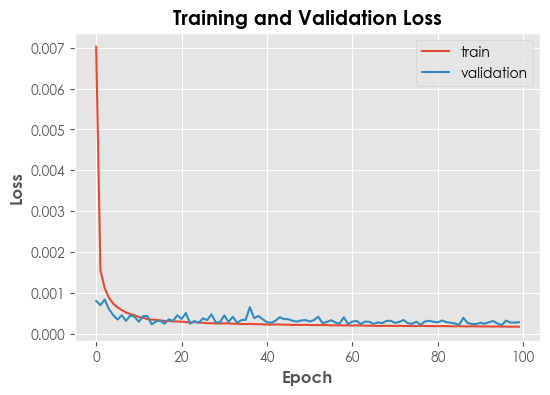

In [10]:
# Plot training and validation loss over epochs to see how well the model is converging.
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Training and Validation Loss', fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.legend()
plt.show()

## 3. Results

In [11]:
# Make predictions using the test set
train_predict = modelo.predict(X_train)
test_predict = modelo.predict(X_test)

# Predictions transformed
y_train_predictions = scaler.inverse_transform(train_predict)
y_test_predictions = scaler.inverse_transform(test_predict)

# Reverse the normalization to get the real values
y_train_real = scaler.inverse_transform([y_train]).T
y_test_real = scaler.inverse_transform([y_test]).T

220/220 [==============================] - 1s 4ms/step


In [12]:
# Create a new dataframe to compare Real values vs Predicted values
predictions_df = pd.DataFrame({'Real_Value': y_test_real.flatten(), 'Prediction': y_test_predictions.flatten()})

# Add a column calculating the Relative Error
predictions_df['Error %'] = abs(predictions_df['Real_Value'] - predictions_df['Prediction'])*100/predictions_df['Real_Value']

# Add datetime column
date = electric_generation_df.iloc[int(len(electric_generation_df)*0.8)+ 2:]['Date']
time = electric_generation_df.iloc[int(len(electric_generation_df)*0.8)+ 2:]['Time']
predictions_df['Date'] = date.values
predictions_df['Time'] = time.values

# Show the predictions dataframe
predictions_df.head()

,Real_Value,Prediction,Error %,Date,Time
0,40899.7369,41097.558594,0.483675,14/03/2023,22
1,39494.3441,39561.632812,0.170376,14/03/2023,23
2,37524.1460,37931.890625,1.086619,14/03/2023,24
3,35736.6560,36172.761719,1.220332,15/03/2023,1
4,34403.3075,34799.351562,1.151180,15/03/2023,2


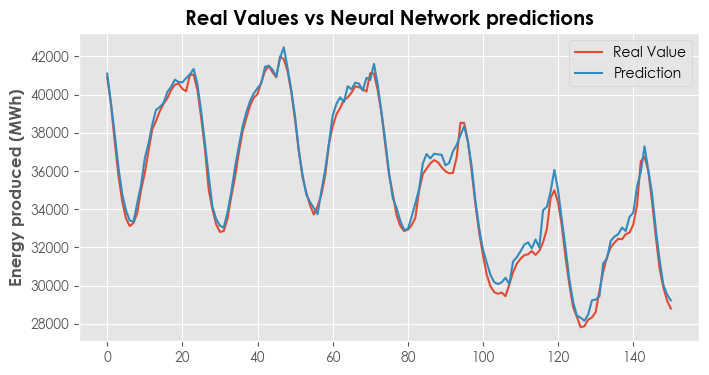

In [13]:
# For spacing reasons, plot just first 150 hours of real values and predictions in the same visualization
plt.figure(figsize = (8, 4))
plt.plot(predictions_df['Real_Value'].loc[:150], label='Real Value')
plt.plot(predictions_df['Prediction'].loc[:150], label='Prediction')
plt.title('Real Values vs Neural Network predictions', fontweight = 'bold')
plt.ylabel('Energy produced (MWh)', fontweight = 'bold')
plt.legend()
plt.show()

In [14]:
# Calculate relevant metrics (RMSE, R²)
rmse_2 = np.sqrt(mean_squared_error(y_test_real, y_test_predictions))
r2_2 = r2_score(y_test_real, y_test_predictions)
mean_relative_error = predictions_df['Error %'].mean()

print(f'Root Mean Squeare Error (RMSE): {rmse_2:.3f}')
print(f'R²: {r2_2*100:.3f}%')
print(f'The relative error average for the predictions is {mean_relative_error:.3f}%')

Root Mean Squeare Error (RMSE): 492.125
R²: 99.309%
The relative error average for the predictions is 0.946%


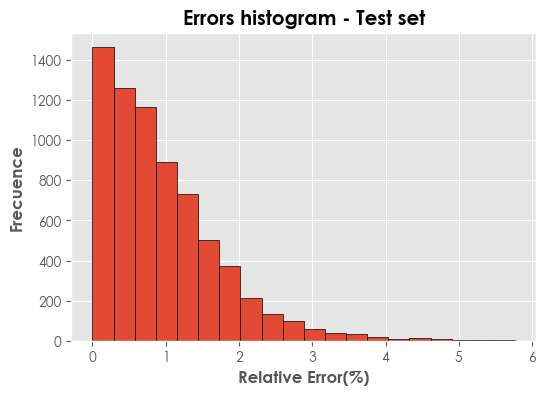

In [15]:
# Create a histogram for the test set and visualize errors shape
plt.figure(figsize = (6, 4))
plt.hist(predictions_df['Error %'], bins = 20, edgecolor = 'black')
plt.title('Errors histogram - Test set', fontweight = 'bold')
plt.xlabel('Relative Error(%)', fontweight = 'bold')
plt.ylabel('Frecuence', fontweight = 'bold')
plt.show()

## 4. Model storage

In [16]:
# Save the model as a h5 file
# modelo.save('model_rnn2.h5')

In [10]:
# Load the model
modelo = load_model('model_rnn.h5')
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 60)            14880     
                                                                 
 dropout (Dropout)           (None, 10, 60)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 40)            16160     
                                                                 
 dropout_1 (Dropout)         (None, 10, 40)            0         
                                                                 
 lstm_2 (LSTM)               (None, 10)                2040      
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [17]:
# Export to csv
predictions_df.to_csv('../Datasets/predictions.csv')